#### Скачивание данных

In [1]:
!pip install vk
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Аккуратно скачаем все посты из группы.

* Используем tqdm для удобного вывода прогресса.
* На всякий случай запомним пост полностью, чтобы не скачивать все заного, если что-то потом "всплывет".
* Просмотры появились в постах не так давно, в старых их просто не будет. Предусмотрим это в коде.
* Вложений тоже может не быть, поэтому будем с ними аккуратнее.

In [2]:
import vk
import datetime
import pandas as pd
from tqdm import tqdm

session = vk.Session(access_token="38479e4a81d854219057927293934ed4d12b1c91afb966101385de82fc3d24310c0d5a039d4a907764504")
api = vk.API(session)

columns = ['text', 'views', 'likes', 'comments', 'is_ad', 'attachments', 'is_repost', 'time', 'raw']
df = pd.DataFrame(columns=columns)

result = api.wall.get(domain='tproger', count=1, v=5.103)
count = result['count']

for offset in tqdm(range(0, count, 100), position=0, leave=True):
    try:
        result = api.wall.get(domain='tproger', count=100, offset=offset, v=5.103)
        for post in result['items']:
            if "views" not in post:
                raise Exception("No views in post")
            """
            print('--- ' * 10)
            print("Пост №:", post['id'])
            print("Размер текста:", len(post['text']))
            print("Просмотры:", post['views']['count'])
            print("Лайки:", post['likes']['count'])
            print("Коменты:", post['comments']['count'])
            print("Реклама?", post['marked_as_ads'])
            print("Число вложений:", len(post['attachments']))
            print("Репост?", post.get('copy_history', None) != None)
            print("Время публикации:", post['date'])
            """
            attachments = post.get('attachments', [])

            df.loc[post['id']] = [
                post['text'],  post['views']['count'], post['likes']['count'], post['comments']['count'],
                post['marked_as_ads'], attachments, post.get('copy_history', None) != None, 
                post['date'], post
            ]
    except Exception as e:
        print("Error:", e)
        break
        


print(df.shape)
df.head()


 27%|██▋       | 67/244 [02:00<05:46,  1.96s/it]

Error: No views in post
(6786, 9)


,text,views,likes,comments,is_ad,attachments,is_repost,time,raw
1653786,Шарите в Java? Есть отличный шанс это продемон...,94364,439,163,0,"[{'type': 'photo', 'photo': {'id': 457676504, ...",False,1581689820,"{'id': 1653786, 'from_id': -30666517, 'owner_i..."
1655514,"Про Си написано достаточно книг, многие из них...",40699,207,55,0,"[{'type': 'photo', 'photo': {'id': 457685524, ...",False,1582733760,"{'id': 1655514, 'from_id': -30666517, 'owner_i..."
1655486,Учёные научились генерировать случайные числа ...,35096,147,18,0,"[{'type': 'photo', 'photo': {'id': 457687288, ...",False,1582718762,"{'id': 1655486, 'from_id': -30666517, 'owner_i..."
1655472,"Сайт i Hate Regex, на котором можно воспользов...",52893,540,13,0,"[{'type': 'photo', 'photo': {'id': 457675569, ...",False,1582703685,"{'id': 1655472, 'from_id': -30666517, 'owner_i..."
1655372,Американка разработала аскетичный телефон с ди...,75579,424,79,0,"[{'type': 'photo', 'photo': {'id': 457682146, ...",False,1582640280,"{'id': 1655372, 'from_id': -30666517, 'owner_i..."


#### Смотрим на данные и правим типы

Итак, мы скачали почти 7000 постов. Посмотрим на типы данных колонок.

In [3]:
for column in columns:
    print(f'{column}: {df[column].dtype}, {len(df[column])}')

text: object, 6786
views: object, 6786
likes: object, 6786
comments: object, 6786
is_ad: object, 6786
attachments: object, 6786
is_repost: object, 6786
time: object, 6786
raw: object, 6786


1) Во всех колонках одинаковое число записей, пропущенных значений нет. Иначе мы смогли бы использовать `dropna` или `fillna`, чтобы их заполнить.

2) У все колонок тип object (категориальные данные), хотя по факту в некоторых числа. Попробуем преобразовать тип.

In [5]:
num_columns = ['views', 'likes', 'comments', 'is_ad', 'is_repost', 'time']

for column in num_columns:
    df[column] = df[column].astype(int)

In [6]:
for column in columns:
    print(f'{column}: {df[column].dtype}, {len(df[column])}')

text: object, 6786
views: int64, 6786
likes: int64, 6786
comments: int64, 6786
is_ad: int64, 6786
attachments: object, 6786
is_repost: int64, 6786
time: int64, 6786
raw: object, 6786


Отлично, теперь в колонках числа, можем на них посмотреть.

In [7]:
df.describe()

,views,likes,comments,is_ad,is_repost,time
count,6786.00000,6786.000000,6786.000000,6786.000000,6786.000000,6.786000e+03
mean,45154.05865,263.656499,23.149425,0.115090,0.039935,1.527658e+09
std,18793.29003,307.291181,69.079965,0.319154,0.195821,2.932440e+07
min,13327.00000,2.000000,0.000000,0.000000,0.000000,1.483218e+09
25%,34219.25000,66.000000,5.000000,0.000000,0.000000,1.500806e+09
50%,41685.50000,157.000000,13.000000,0.000000,0.000000,1.528349e+09
75%,50006.25000,343.000000,26.000000,0.000000,0.000000,1.552212e+09
max,303645.00000,5044.000000,4558.000000,1.000000,1.000000,1.582734e+09


views


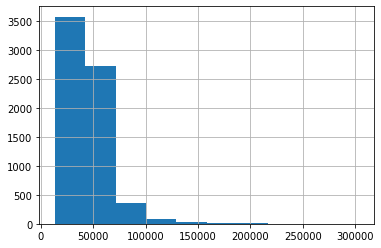

likes


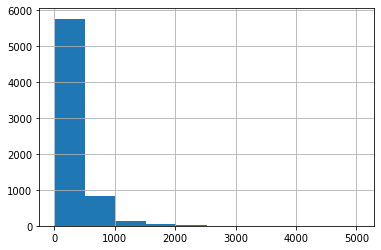

comments


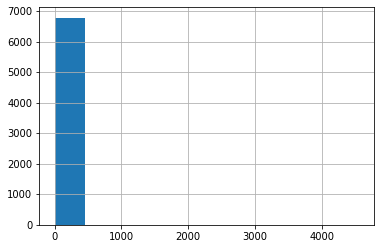

is_ad


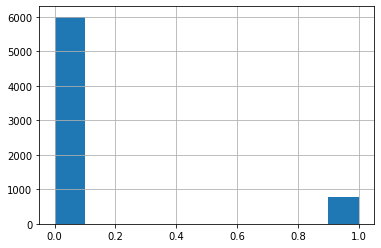

is_repost


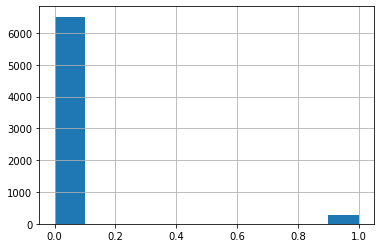

time


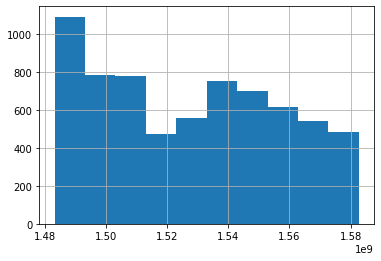

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

num_columns = ['views', 'likes', 'comments', 'is_ad', 'is_repost', 'time']

for column in num_columns:
    print(column)
    df[column].hist()
    plt.show()

В данных выше мы можем увидеть интересные моменты: есть посты с аномально большим числом лайков и комментов. Можно на них посмотреть.

In [11]:
df.sort_values('comments', ascending=False)[:5]

,text,views,likes,comments,is_ad,attachments,is_repost,time,raw
1587910,В приложении «ВКонтакте» для Android появилась...,122615,312,4558,0,"[{'type': 'photo', 'photo': {'id': 456322633, ...",0,1555400095,"{'id': 1587910, 'from_id': -30666517, 'owner_i..."
1611436,Давайте устроим пятничный интерактив.\n\nВ ком...,83107,119,1936,0,"[{'type': 'photo', 'photo': {'id': 457405135, ...",0,1563542940,"{'id': 1611436, 'from_id': -30666517, 'owner_i..."
1579542,Сегодня в России прошли митинги против изоляци...,79485,492,596,0,"[{'type': 'photo', 'photo': {'id': 456277864, ...",0,1552245134,"{'id': 1579542, 'from_id': -30666517, 'owner_i..."
1624064,"Ностальгируем, не стесняемся",59648,180,576,0,"[{'type': 'photo', 'photo': {'id': 457486163, ...",0,1568370266,"{'id': 1624064, 'from_id': -30666517, 'owner_i..."
1645176,Что вас ждёт в Новом году? Предлагаем вам загл...,43822,37,538,0,"[{'type': 'photo', 'photo': {'id': 457635228, ...",0,1577714813,"{'id': 1645176, 'from_id': -30666517, 'owner_i..."


In [12]:
df.sort_values('likes', ascending=False)[:5]

,text,views,likes,comments,is_ad,attachments,is_repost,time,raw
1566145,,212472,5044,144,0,"[{'type': 'photo', 'photo': {'id': 456272768, ...",0,1546290005,"{'id': 1566145, 'from_id': -30666517, 'owner_i..."
1495237,Видеокурс «Основы программирования». \n \nРусс...,64538,4359,11,0,"[{'type': 'video', 'video': {'access_key': '76...",0,1500307628,"{'id': 1495237, 'from_id': -30666517, 'owner_i..."
1452322,"Year++, программисты!",135403,2972,127,0,"[{'type': 'photo', 'photo': {'id': 456240507, ...",0,1483218155,"{'id': 1452322, 'from_id': -30666517, 'owner_i..."
1483520,Подготовили для вас перевод подробного руковод...,96807,2925,17,0,"[{'type': 'link', 'link': {'url': 'https://tpr...",0,1493226250,"{'id': 1483520, 'from_id': -30666517, 'owner_i..."
1520134,"Привет. Просто анимированная форма логина, зац...",76552,2661,66,0,"[{'type': 'doc', 'doc': {'id': 460704137, 'own...",0,1519661280,"{'id': 1520134, 'from_id': -30666517, 'owner_i..."


#### Feature Engineering и предварительная обработка

Визуально мы заметили, что некоторые посты отмечены хэш-тегом "\#партнерский". Попробуем найти такие посты и посмотреть, отмечены ли они как реклама.

Для это применим функцию к столбцу text и получим новый столбец.

In [13]:
def is_partner(text):
    if "#партнерский" in text.replace('ё', 'е').lower():
        return 1
    else:
        return 0
    
df['is_partner'] = df['text'].apply(is_partner)

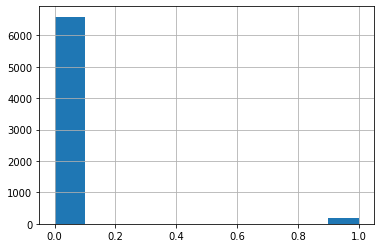

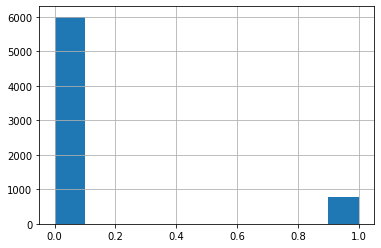

In [14]:
df['is_partner'].hist()
plt.show()
df['is_ad'].hist()
plt.show()

Интересно, а все ли посты, отмеченные, как партнерские, помечены, как реклама.

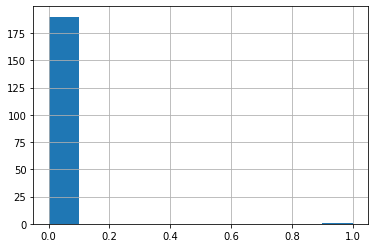

In [15]:
df[ df['is_partner'] == 1 ]['is_ad'].hist()

Оказывается, нет! Выходит, мы только что придумали, как достать новую информацию из уже имеющихся данных. Это называется **feature ingineerring**. Именно в этом и состоит *искусство* машинного обучения.

https://habr.com/ru/company/mlclass/blog/248129/

Еще у нас есть время публикации. Попробуем достать из него, например, день недели.

https://stackoverflow.com/questions/9847213/how-do-i-get-the-day-of-week-given-a-date

In [16]:
from datetime import date
import calendar

# test
print("Today:", calendar.day_name[datetime.datetime.today().weekday()])


def get_weekday(unix_time):
    date = datetime.datetime.fromtimestamp(unix_time)
    return calendar.day_name[date.weekday()]


df['weekday'] = df['time'].apply(get_weekday)   

Today: Wednesday


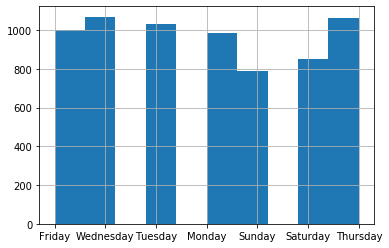

In [17]:
df['weekday'].hist()

Как отправить эти данные в машину? Превратить в числа. Первое что приходит в голову - просто выдать номер для каждого для недели.

Но тогда получится, что воскренье больше понедельника, что не так - они идут подряд, а это может сбить некоторые модели с толку. Поэтому вместо этого создадим по булевому признаку для каждого дня недели.

In [18]:
df = pd.concat([df, pd.get_dummies(df['weekday'], prefix='is_')] , axis=1)

In [19]:
df.head()

,text,views,likes,comments,is_ad,attachments,is_repost,time,raw,is_partner,weekday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday
1653786,Шарите в Java? Есть отличный шанс это продемон...,93860,435,159,0,"[{'type': 'photo', 'photo': {'id': 457676504, ...",0,1581689820,"{'id': 1653786, 'from_id': -30666517, 'owner_i...",0,Friday,1,0,0,0,0,0,0
1655514,"Про Си написано достаточно книг, многие из них...",13327,78,43,0,"[{'type': 'photo', 'photo': {'id': 457685524, ...",0,1582733760,"{'id': 1655514, 'from_id': -30666517, 'owner_i...",0,Wednesday,0,0,0,0,0,0,1
1655486,Учёные научились генерировать случайные числа ...,24401,112,13,0,"[{'type': 'photo', 'photo': {'id': 457687288, ...",0,1582718762,"{'id': 1655486, 'from_id': -30666517, 'owner_i...",0,Wednesday,0,0,0,0,0,0,1
1655472,"Сайт i Hate Regex, на котором можно воспользов...",40290,395,7,0,"[{'type': 'photo', 'photo': {'id': 457675569, ...",0,1582703685,"{'id': 1655472, 'from_id': -30666517, 'owner_i...",0,Wednesday,0,0,0,0,0,0,1
1655372,Американка разработала аскетичный телефон с ди...,57696,349,77,0,"[{'type': 'photo', 'photo': {'id': 457682146, ...",0,1582640280,"{'id': 1655372, 'from_id': -30666517, 'owner_i...",0,Tuesday,0,0,0,0,0,1,0


Сделаем еще пару признаков - длина текста и количество вложений.

In [20]:
df['attachments_len'] = df['attachments'].apply(lambda x:len(x))
df['text_len'] = df['text'].apply(lambda x:len(x))

#### Убираем аутлайнеров

Как мы видели ранее, в наших данных есть очень нетипичные почты, которые сильно отличаются от остальных. Например, пост про новый год, у которого очень много лайков.

Если мы хотим сделать модель с более высокой обобщающей способностью, такие данные полезно отбросить. Например, можно посмотреть на стандартное отклонение и отбросить все, что лежит сильно дальше среднего.

Однако, становится ли от этого лучше, стоит отдельно проверить позже.

In [21]:
learn_df = df.drop(columns=['text', 'attachments', 'raw', 'weekday'])

In [22]:
def not_outliner(value, mean_value, std_value):
    if mean_value - 3 * std_value < value < mean_value + 3 * std_value:
        return True
    return False

for column in learn_df.columns:
    mean_value = df[column].mean()
    std_value = df[column].std()
    regular_posts = learn_df[column].apply(lambda x: not_outliner(x, mean_value, std_value))
    learn_df = learn_df[regular_posts]

print(df.shape)
print(learn_df.shape)

(6786, 20)
(5715, 16)


#### Обучаем модели

In [23]:
X = learn_df.drop(columns=['views'])
Y = learn_df['views']

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

models = {
    "linear": LinearRegression(),
    "linear with regularisation": Ridge(),
    "tree": DecisionTreeRegressor(max_depth=5),
    "forest": RandomForestRegressor(),
    "gradient_boosting": GradientBoostingRegressor()
}

for model_name in models:
    models[model_name].fit(X_train, Y_train)
    train_predictions = models[model_name].predict(X_train)
    test_predictions = models[model_name].predict(X_test)
    
    print("")
    print("Model: ", model_name)
    print("Train MSE:", mean_squared_error(Y_train, train_predictions) ** 0.5)
    print("Test MSE:", mean_squared_error(Y_test, test_predictions) ** 0.5)


Model:  linear
Train MSE: 9211.932248535137
Test MSE: 9857.391565544594

Model:  linear with regularisation
Train MSE: 9211.932612227418
Test MSE: 9857.427161054646

Model:  tree
Train MSE: 8282.432219584172
Test MSE: 9312.09861699642

Model:  forest
Train MSE: 2886.843032068556
Test MSE: 8013.346770311144

Model:  gradient_boosting
Train MSE: 7021.634811025651
Test MSE: 8027.920873070439


На данный момент лучше всего работает случайный лес и градиентный бустинг. Можно посмотреть, на какие признаки он опирается.

In [27]:
for (w, n) in sorted(zip(models["forest"].feature_importances_, X.columns)):
    print(n, " - ", w)

is_partner  -  0.0
is_repost  -  0.0
is__Monday  -  0.004472083969077294
is__Friday  -  0.005267770391535488
is__Tuesday  -  0.005857119727389557
is__Saturday  -  0.006079554378001615
is__Thursday  -  0.006170388754875776
is__Wednesday  -  0.006649746058552718
is_ad  -  0.0071875273845313165
is__Sunday  -  0.009645903020315462
attachments_len  -  0.015086326509830305
comments  -  0.06723588845170486
text_len  -  0.09049457773415014
time  -  0.21436875234209185
likes  -  0.5614843612779438


Чтобы посмотреть, влияют ли признаки негативно или положительно можем дополнительно посмотреть на регрессию.

In [28]:
for (w, n) in sorted(zip(models["linear"].coef_, X.columns)):
    print(n, " - ", w)

attachments_len  -  -1411.436919065821
time  -  -1055.0983785276426
is__Thursday  -  -376.62449874211086
is__Wednesday  -  -356.4904341017434
is__Tuesday  -  -271.2596167032073
is__Monday  -  -130.34111203139494
is__Friday  -  -81.18268923383033
is_partner  -  -2.2737367544323206e-13
is_repost  -  2.2737367544323206e-13
is__Saturday  -  476.44283617413447
text_len  -  524.0201878327616
is__Sunday  -  888.0244579315104
is_ad  -  1117.9295341139302
comments  -  1968.650029389038
likes  -  9358.417243624968


Выходит, что лучше всего публиковать посты в воскресенье, а хуже всего в среду. Много вложений - это плохо.